In [1]:
# %pip install numpy
# %pip install pandas
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install pylatexenc
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import torch
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub

import warnings
warnings.filterwarnings("ignore")

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths
##### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf {path}/chest_xray/chest_xray/train/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store

In [5]:
train_path_norm = f'{path}/chest_xray/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Check data

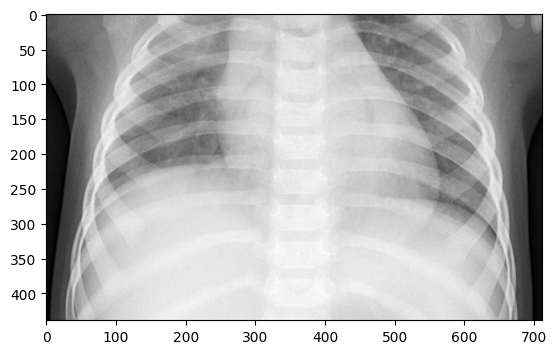

In [6]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

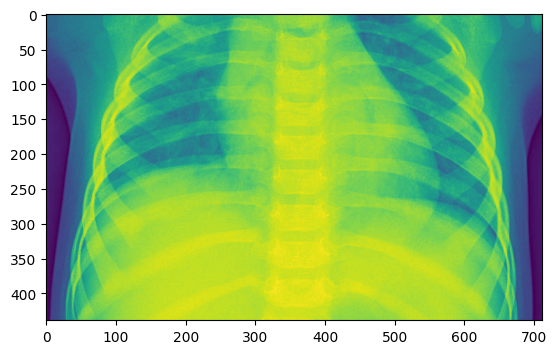

In [7]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [8]:
img_size = (128, 128)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=(256, 256)):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

Found 5216 validated image filenames belonging to 2 classes.


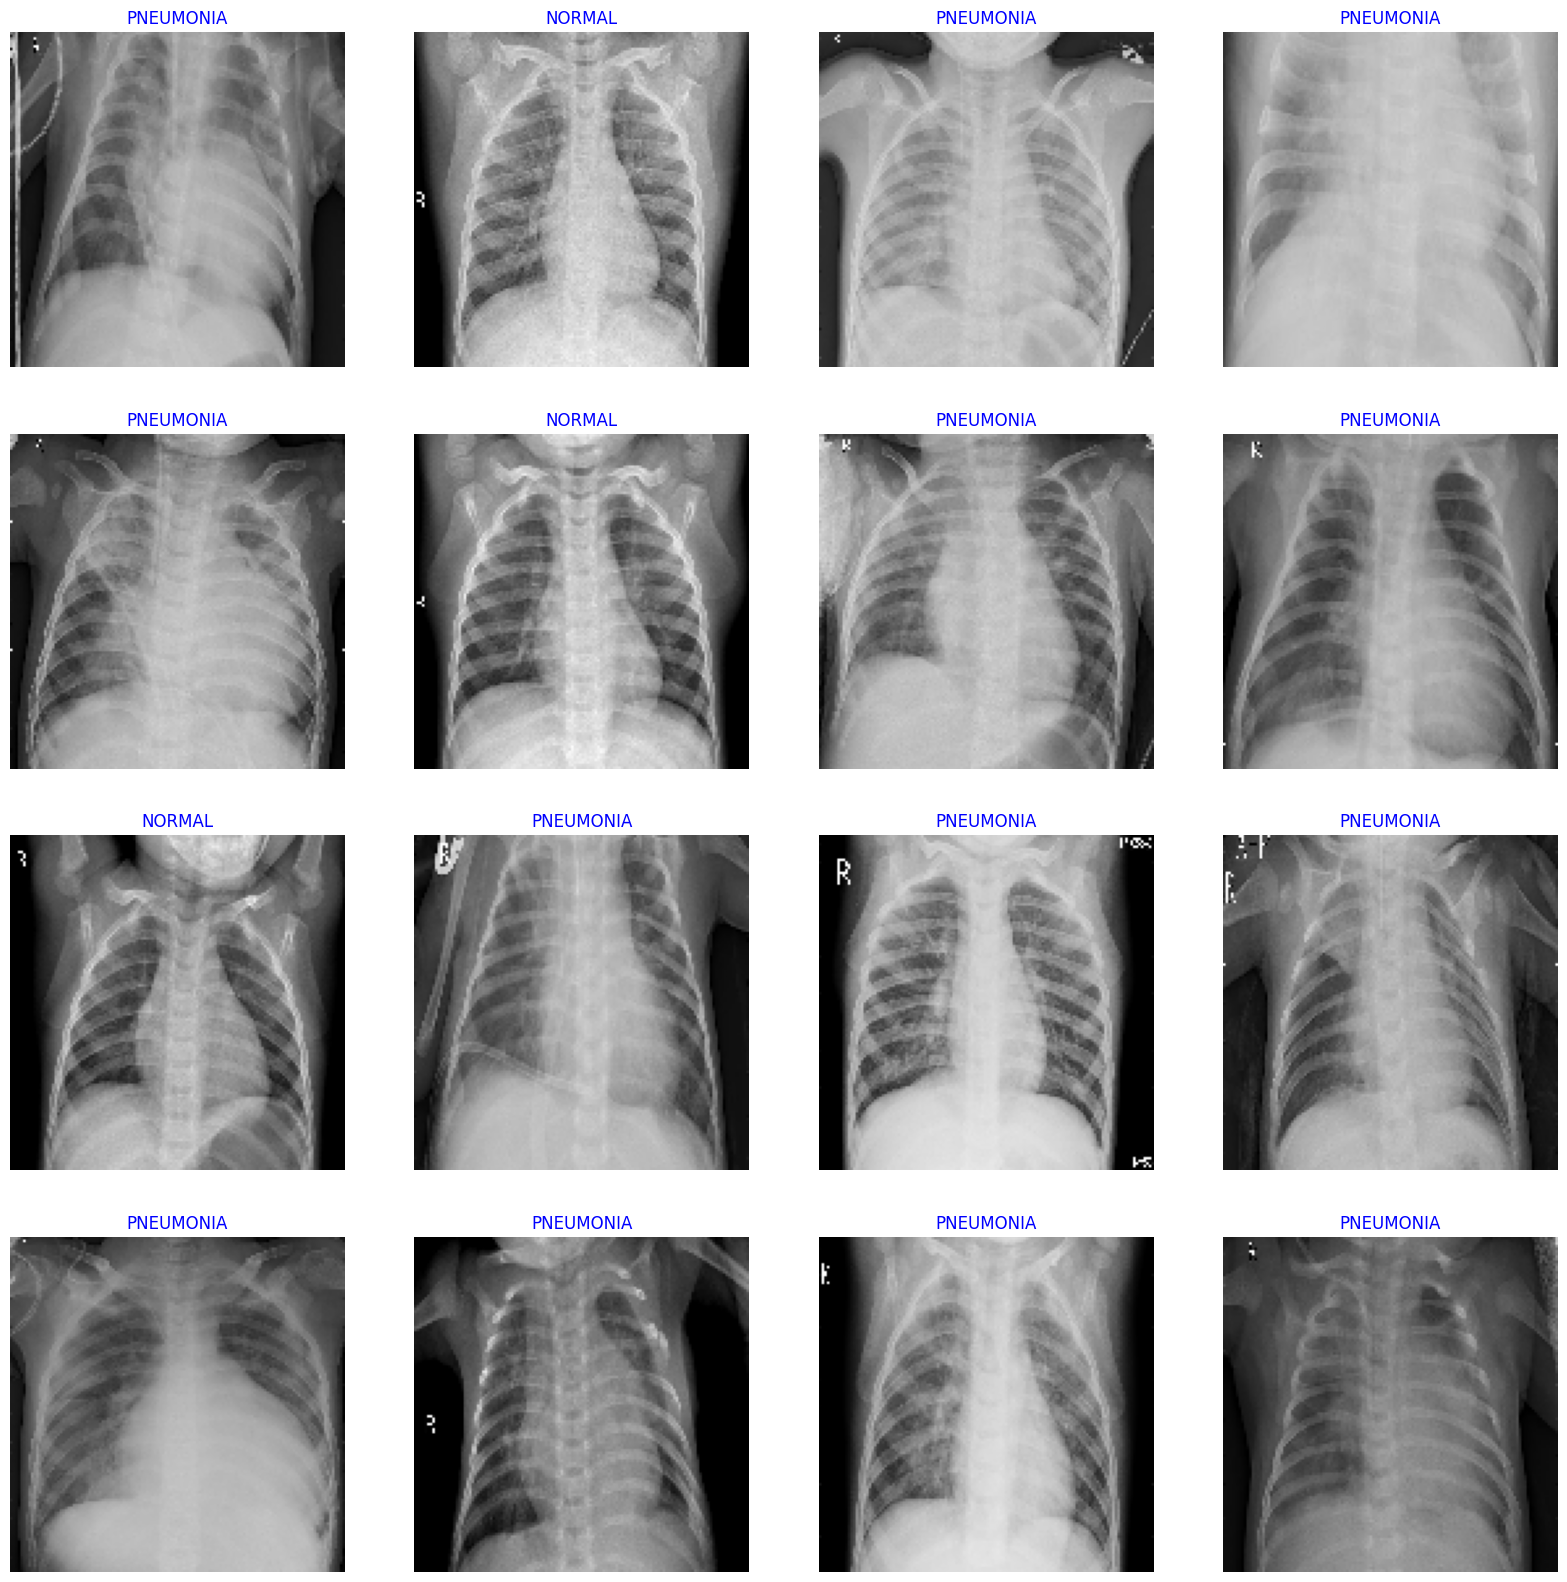

In [9]:
def create_dataframe_from_directory(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    labels = [label] * len(filepaths)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

df_norm = create_dataframe_from_directory(train_path_norm, 'NORMAL')
df_pneu = create_dataframe_from_directory(train_path_pneu, 'PNEUMONIA')

train_df = pd.concat([df_norm, df_pneu], ignore_index=True)

train_df = train_df.sample(frac=1).reset_index(drop=True)

def scalar(img):
    return img

batch_size = 32
tr_gen = ImageDataGenerator(preprocessing_function= scalar)


train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= img_size,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= batch_size
)

g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen)      
plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255     
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

#### Proportional sampling for balanced dataset

In [10]:
num_samples = 1000
num_samples_test = 200

norm_ratio = 1341 / (1341 + 3875)
pneu_ratio = 3875 / (1341 + 3875)

num_samples_norm = int(num_samples * norm_ratio)
num_samples_pneu = int(num_samples * pneu_ratio)

num_samples_norm_test = int(num_samples_test * norm_ratio)
num_samples_pneu_test = int(num_samples_test * pneu_ratio)

In [11]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, num_samples_norm, target_size=img_size)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, num_samples_pneu, target_size=img_size)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, num_samples_norm_test, target_size=img_size)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, num_samples_pneu_test, target_size=img_size)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)

#### Dimensionality Reduction with PCA

In [12]:
pca = PCA(n_components=16)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#### Convert to tensor for QNN compatibility

In [13]:
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Compute class weights to balance classes

In [14]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

#### Define the Quantum Neural Network Circuit

In [15]:
def parity(x):
    return f"{bin(x)}".count("1") % 2

# Initialize QNN
num_qubits = 16
qnn_circuit = QNNCircuit(num_qubits=num_qubits)
qnn = SamplerQNN(
    circuit=qnn_circuit,
    interpret=parity,
    output_shape=2
)

#### Set random weights for testing

In [16]:
weights = np.random.rand(qnn.num_weights)

#### Forward pass with test data

In [17]:
X_test_numpy = X_test_tensor.numpy()
outputs_test = qnn.forward(input_data=X_test_numpy, weights=weights)
predictions = (outputs_test > 0.5).astype(int)

#### Calculate evaluation metrics

In [18]:
X_test_numpy = X_test_tensor.numpy()
outputs_test = qnn.forward(input_data=X_test_numpy, weights=weights)

if outputs_test.ndim > 1 and outputs_test.shape[1] > 1:
    predictions = outputs_test.argmax(axis=1)
else:
    predictions = (outputs_test > 0.5).astype(int)

y_test = y_test_tensor.numpy().astype(int)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary', zero_division=1)
recall = recall_score(y_test, predictions, average='binary', zero_division=1)
f1 = f1_score(y_test, predictions, average='binary', zero_division=1)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: {conf_matrix}")

Accuracy: 0.49748743718592964
Precision: 0.74
Recall: 0.5
F1 Score: 0.5967741935483871
Confusion Matrix: [[25 26]
 [74 74]]


#### Predicted probability for Positive Class

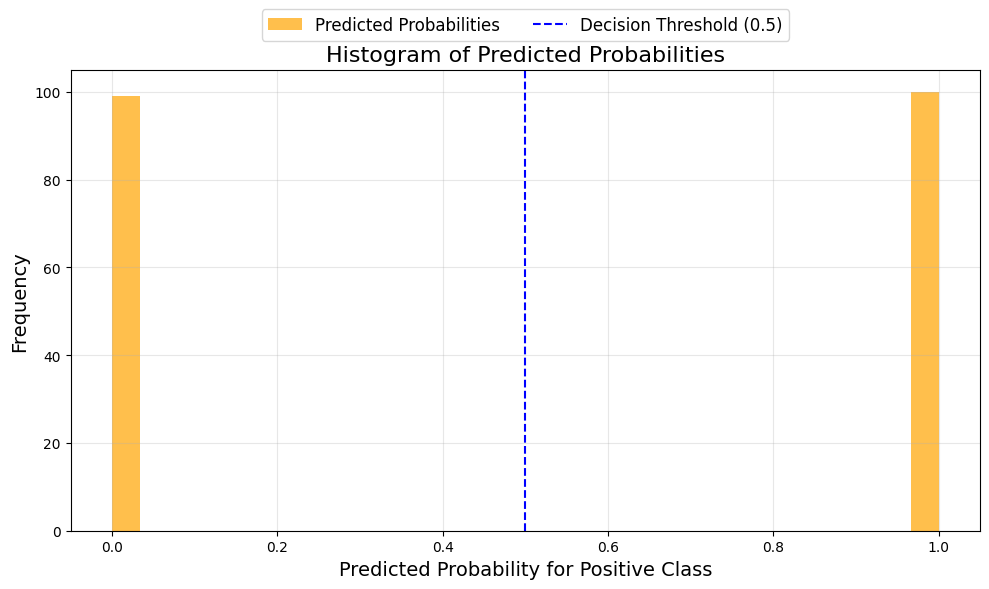

In [19]:
if outputs_test.ndim > 1 and outputs_test.shape[1] > 1:
    predictions = outputs_test.argmax(axis=1)
else:
    predictions = (outputs_test > 0.5).astype(int)

y_pred_probabilities_tensor = torch.tensor(predictions, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

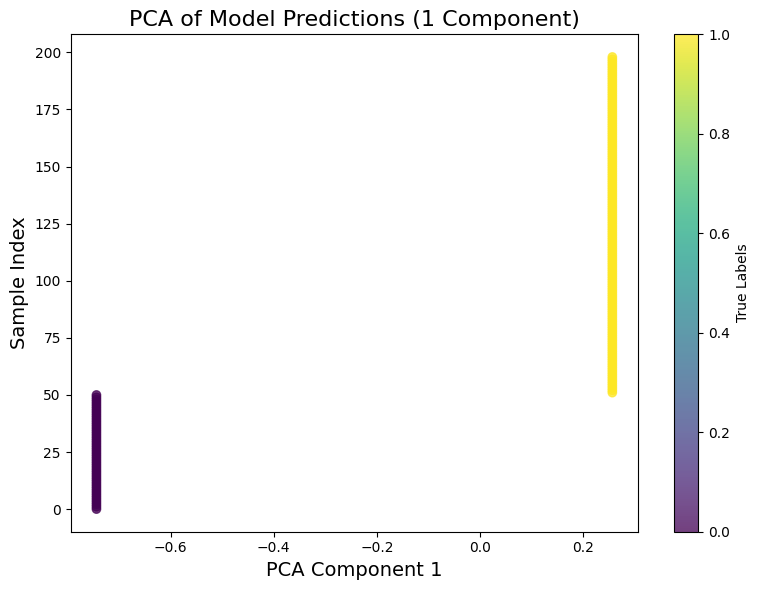

In [20]:
if y_test.ndim == 1:
    labels_test_reshaped = y_test.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca, range(len(features_pca)), c=y_test, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plotting the confusion matrix

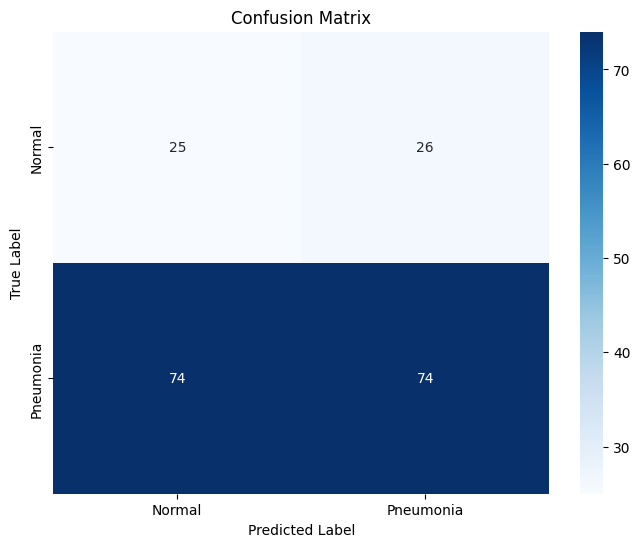

In [21]:

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(conf_matrix)

In [22]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright